In [631]:
import matplotlib.pyplot as plt
import pickle

In [632]:
%load_ext autoreload
%autoreload 2
from LayoutUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [633]:
with open('graph_instances_lst.pkl', 'rb') as file:
    graph_instances_lst = pickle.load(file)

In [634]:
molecules_G = graph_instances_lst[42]

In [635]:
molecules_G

{'layout_spec': <networkx.classes.digraph.DiGraph at 0x23bd16bf548>,
 'molecules': [{'obstacle_G_ix': None,
   'edge': None,
   'params': [None, None],
   'molecule': <networkx.classes.digraph.DiGraph at 0x23bd1701348>,
   'molecule_ix': 33},
  {'obstacle_G_ix': 0,
   'edge': ('g90001', 'g90004'),
   'params': [None],
   'molecule': <networkx.classes.digraph.DiGraph at 0x23bce4a0448>,
   'molecule_ix': 1},
  {'obstacle_G_ix': 1,
   'edge': (160001, 160003),
   'params': [None],
   'molecule': <networkx.classes.digraph.DiGraph at 0x23bce600308>,
   'molecule_ix': 11}]}

In [636]:
node_data, num_rooms, group_sizes, group_ids, groups_to_connect, obstacle_ids = load_parse_molecules(molecules_G)
print(obstacle_ids)

[(2, {'data': [['19', '17', '14'], ['11']]}), (1, {'data': [['17', '14', '18'], ['0']]}), (0, {'data': [['6']]})]
[(2, 1, {'obstacle_id': 11}), (1, 0, {'obstacle_id': 1})]
{11: (2, 1), 1: (1, 0)}


In [637]:
node_data

{2: {'data': [['19', '17', '14'], ['11']]},
 1: {'data': [['17', '14', '18'], ['0']]},
 0: {'data': [['6']]}}

In [638]:
num_columns = 4
grid_size = 30
min_room_size = 3
roomspace = grid_size - (num_columns + 1)

In [639]:
divisions = get_divisions(roomspace, num_columns, min_room_size)
walkable_points, chosen_rooms = get_choosen_rooms(divisions, min_room_size, num_rooms)

distances = {}
for i, r1 in enumerate(chosen_rooms):
    for j, r2 in enumerate(chosen_rooms):
        if i < j:
            distances[(i, j)] = get_distance(r1, r2)

sorted_pairs = list(sorted(map(lambda x: (x[0], x[1]), distances.items()), key=lambda x: x[1]))
G = get_grid_graph(grid_size, walkable_points, chosen_rooms)
paths = get_paths(G, sorted_pairs, chosen_rooms, grid_size)
paths_lst = [(k, v) for k, v in paths.items()]
rooms_points = get_room_points(chosen_rooms)
room_G = get_rooms_graph(chosen_rooms, paths_lst, rooms_points)

In [640]:
available_indices = set(range(num_rooms))  # num rooms=součet

splits_it = iterate_G(available_indices, group_sizes, 0, room_G)

found = False
for i, split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels) == len(group_sizes):
            crossing_edges = get_crossing_edges_list(skels, room_G, groups_to_connect, paths_lst)
            #if None in crossing_edges:
            #    print(crossing_edges)
            #    continue
            found = True
            print(i, '::::', skels)
            break
    #if i>100:
    if found == True:
        break
#crossing_edges = [] # zakomentovat
#string = get_layout_str(walkable_points,skels,crossing_edges,paths_lst,grid_size)
#print(string)

[(2, (2, 1)), (10, (1, 0))]
0 :::: [{'edges': {0}, 'intersections': set()}, {'edges': {1}, 'intersections': set()}, {'edges': {9}, 'intersections': {3, 13, 14}}]


In [641]:
vertices_edges_dict = nx.get_edge_attributes(room_G, 'corridor_key')

In [642]:
skels_rooms_dict = get_rooms_from_skels(skels, vertices_edges_dict)

In [643]:
skels_rooms_dict

{0: [(0, 1)], 1: [(2, 3)], 2: [(4, 5)]}

In [644]:
room_ids_from_node_data = get_room_ids_for_group(skels_rooms_dict)

In [645]:
room_ids_from_node_data

{0: {0, 1}, 1: {2, 3}, 2: {4, 5}}

In [646]:
idx = crossing_edges[0][0]
grps = crossing_edges[0][1]
intersect = intersect_first_group(idx, grps, room_G, skels, paths_lst)
print(intersect)

False


In [647]:
obstacle_room_id = get_obstacle_room(idx, grps, room_G, skels, paths_lst, room_ids_from_node_data)
obstacle_pos = get_obstacle_pos(obstacle_room_id,idx,paths_lst,room_G)

In [648]:
# 1. skels edge spojuje 2 roomky (20 - edge spojuje 2 vrcholy (roomy))
# 2. funkce bude vracet list množin (počet množin = počet group, každá množina bude mít tolik prvků - indexů roomek, kolik je v groupě roomek)
# 3. ke každé groupě znám které symboly patří do těch jednotlivých roomek (dle indexů)
#   - funkce vezme index roomky z kroku 2 a počet atomů a vrátí pozice rovnající se počtu atomů, které nesmí být stejné, pozice přiřadím atomům které v té roomce mají být
#### - pro každou roomku vzít atomy, index roomky z kroku 2 a funkce vrátí
# skels:
# {0: [(0, 1)], 1: [(2, 4), (2, 3)], 2: [(5, 6)]}
# room_ids from groups node_data:
# {2: {0, 1}, 1: {2, 3, 4}, 0: {5}}
# node_data:
# {2: {'data': [['13'], ['8', '7']]},
# 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
# 0: {'data': [['17']]}}

In [649]:
node_data

{2: {'data': [['19', '17', '14'], ['11']]},
 1: {'data': [['17', '14', '18'], ['0']]},
 0: {'data': [['6']]}}

In [650]:
groups_rooms_points = get_room_points_from_node_data(room_ids_from_node_data, room_G)
groups_rooms_points

defaultdict(list,
            {0: [(0,
               [(18, 0),
                (18, 1),
                (18, 2),
                (18, 3),
                (18, 4),
                (18, 5),
                (18, 6),
                (19, 0),
                (19, 1),
                (19, 2),
                (19, 3),
                (19, 4),
                (19, 5),
                (19, 6),
                (20, 0),
                (20, 1),
                (20, 2),
                (20, 3),
                (20, 4),
                (20, 5),
                (20, 6),
                (21, 0),
                (21, 1),
                (21, 2),
                (21, 3),
                (21, 4),
                (21, 5),
                (21, 6),
                (22, 0),
                (22, 1),
                (22, 2),
                (22, 3),
                (22, 4),
                (22, 5),
                (22, 6),
                (23, 0),
                (23, 1),
                (23, 2),
           

In [651]:
node_data

{2: {'data': [['19', '17', '14'], ['11']]},
 1: {'data': [['17', '14', '18'], ['0']]},
 0: {'data': [['6']]}}

In [652]:
idx = crossing_edges[1][0]
groups = crossing_edges[1][1]
ob_room = get_obstacle_room(idx, groups, room_G, skels, paths_lst, room_ids_from_node_data)
ob_pos = get_obstacle_pos(ob_room, idx, paths_lst, room_G)
print(ob_pos)

(3, 11)


In [653]:
obstacles = get_obstacle_id_and_pos(crossing_edges, room_G, skels, paths_lst, room_ids_from_node_data, obstacle_ids)
obstacles

(2, 1)
(1, 0)


[(11, (5, 25)), (1, (4, 12))]

In [654]:
atom_placements = get_atom_placements(groups_rooms_points, node_data, obstacles)
print(atom_placements)

[(5, 25), (4, 12), (3, 25)]
[(5, 25), (4, 12), (3, 25), (0, 27)]
[(5, 25), (4, 12), (3, 25), (0, 27), (2, 25)]
[(5, 25), (4, 12), (26, 26)]
[(5, 25), (4, 12), (0, 23)]
[(5, 25), (4, 12), (0, 23), (5, 12)]
[(5, 25), (4, 12), (0, 23), (5, 12), (4, 19)]
[(5, 25), (4, 12), (11, 13)]
[(5, 25), (4, 12), (19, 5)]
defaultdict(<class 'list'>, {4: [('19', (3, 25), 2), ('17', (0, 27), 2), ('14', (2, 25), 2)], 5: [('11', (26, 26), 2)], 2: [('17', (0, 23), 1), ('14', (5, 12), 1), ('18', (4, 19), 1)], 3: [('0', (11, 13), 1)], 0: [('6', (19, 5), 0)]})


In [655]:
print(atom_placements)

defaultdict(<class 'list'>, {4: [('19', (3, 25), 2), ('17', (0, 27), 2), ('14', (2, 25), 2)], 5: [('11', (26, 26), 2)], 2: [('17', (0, 23), 1), ('14', (5, 12), 1), ('18', (4, 19), 1)], 3: [('0', (11, 13), 1)], 0: [('6', (19, 5), 0)]})


In [656]:
with open('obstacle_dic.pkl', 'rb') as file:
    obstacle_dic = pickle.load(file)
with open('symbol_mappings.pkl', 'rb') as file:
    symbol_mappings = pickle.load(file)

In [657]:
obstacles

[(11, (5, 25)), (1, (4, 12))]

In [658]:
atom_obstacles_dict = get_atom_obstacle_ids_and_positions(atom_placements, obstacles, obstacle_dic)
atom_obstacles_dict

{(5, 25): 11065,
 (4, 12): 11005,
 (4, 26): 19,
 (1, 28): 17,
 (3, 26): 14,
 (27, 27): 11,
 (1, 24): 17,
 (6, 13): 14,
 (5, 20): 18,
 (12, 14): 0,
 (20, 6): 6}

In [659]:
atom_obstacles_dict_converted = convert_to_ascii(atom_obstacles_dict, symbol_mappings)
atom_obstacles_dict_converted

{(5, 25): 'Ы',
 (4, 12): 'Ц',
 (4, 26): 'τ',
 (1, 28): 'ς',
 (3, 26): 'ο',
 (27, 27): 'μ',
 (1, 24): 'ς',
 (6, 13): 'ο',
 (5, 20): 'σ',
 (12, 14): 'α',
 (20, 6): 'η'}

In [660]:
crossing_edge_this = [c_e[0] for c_e in crossing_edges]
print(crossing_edge_this)

[2, 10]


In [661]:
agent_pos = get_agent_pos(groups_rooms_points, molecules_G)

In [662]:
agent_pos

(1, 26)

In [663]:
layout = get_layout_str_with_atoms(walkable_points, skels, crossing_edge_this, paths_lst, grid_size, atom_placements, obstacles, atom_obstacles_dict_converted, agent_pos)
print(layout)

wwwwwwwwwwwwwwwwwwwwwwwwwwwwww
wwwwwwwwwwwww...........ςwA.ςw
wwwwwwwwwwwww............w...w
wwwwwwwwwwwww............wο..w
wwww........Ц............wτ..w
wwww.wwwwwwww.......σ....Ы...w
wwww.wwwwwwwwο...........ww.ww
wwww.wwwwwwwwwwwwwww.wwwwww.ww
wwww.wwwwwwww............ww..w
wwww.wwwwwwww............www.w
wwww.wwwwwwww............www.w
wwww.wwwwwwww............www.w
wwww.wwwwwwww.α..........www.w
wwww.wwwwwwww............www.w
wwww.wwwwwwww............www.w
wwww.wwwwwwwwwwwwwwwwwwwwwww.w
wwww.wwwwwwwwwwwwwwwwwwwwwww.w
wwww.wwwwwwwwwwwwwwwwwwwwwww.w
wwww.wwww...wwwwwwwwwwwwww...w
w.......w...wwwwwwwwwwwwww...w
w.....η.w...wwwwwwwwwwwwww...w
w.......w...wwwwwwwwwwwwww...w
w.......w...wwwwwwwwwwwwww...w
w...........wwwwwwwwwwwwww...w
w.......w...wwwwwwwwwwwwww...w
wwwwwwwww...wwwwwwwwwwwwww...w
wwwwwwwww...wwwwwwwwwwwwww...w
wwwwwwwww...wwwwwwwwwwwwww.μ.w
wwwwwwwww...wwwwwwwwwwwwww...w
wwwwwwwwwwwwwwwwwwwwwwwwwwwwww



In [664]:
with open('generated_layout.txt', 'w', encoding="utf-8") as file:
    file.write(layout)

In [665]:
#DEBUG (deprecated):

In [666]:
print(skels)

[{'edges': {0}, 'intersections': set()}, {'edges': {1}, 'intersections': set()}, {'edges': {9}, 'intersections': {3, 13, 14}}]


In [667]:
sorted_pairs = list(sorted(map(lambda x: (x[0], x[1]), distances.items()), key=lambda x: x[1]))

In [668]:
G = get_grid_graph(grid_size, walkable_points, chosen_rooms)

In [669]:
paths = get_paths(G, sorted_pairs, chosen_rooms, grid_size)

In [670]:
paths_lst = [(k, v) for k, v in paths.items()]
rooms_points = get_room_points(chosen_rooms)

room_G = get_rooms_graph(chosen_rooms, paths_lst, rooms_points)

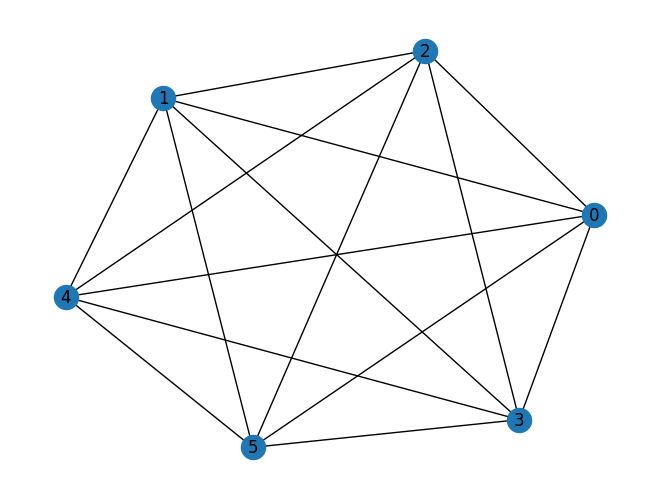

In [671]:
nx.draw(room_G, with_labels=True)
edgs = room_G.edges(data=True)